Построить классификатор, который "угадывает" персонажа по его фразе. Baseline: равновероятный выбор между всеми главными героями.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import itertools
from plotting import plot_confusion_matrix, plot_classification_report
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
%matplotlib inline

Примерный план действий: 

выделить реплики главных персонажей

сгруппировать их по героям

нормализовать (свой выбор процедур объяснить (например, нужно ли включать в стоп-лист обсценную лексику?);

векторизовать (например, CountVectorizer)

отрезать поверочную выборку (эту часть не трогаем до последней проверки). 

In [2]:
df = pd.read_csv("All-seasons.csv", header=0)
top = df.groupby(['Character']).size().sort_values(ascending=False)[:10]
top

Character
Cartman         9774
Stan            7680
Kyle            7099
Butters         2602
Randy           2467
Mr. Garrison    1002
Chef             917
Kenny            881
Sharon           862
Mr. Mackey       633
dtype: int64

In [3]:
chars = top[:5].axes[0]
chars

Index(['Cartman', 'Stan', 'Kyle', 'Butters', 'Randy'], dtype='object', name='Character')

In [4]:
new_df = pd.DataFrame([])

In [5]:
for el in chars:
    new_df = pd.concat([new_df, df[df['Character'] == el][['Character', 'Line']].sample(frac=1)[:2467]])
new_df.groupby(['Character']).size()

Character
Butters    2467
Cartman    2467
Kyle       2467
Randy      2467
Stan       2467
dtype: int64

In [6]:
# new_df['Line'] = new_df.Line.map(lambda text: text.lower())
new_df['Line'] = new_df.Line.apply(RegexpTokenizer(r'\w+').tokenize)
new_df.head()

,Character,Line
39741,Cartman,"[However, long, Craig, wants, it, to, last, T,..."
25595,Cartman,"[Oh, looks, like, Kyle, is, commenting, on, my..."
64184,Cartman,[Naaaa]
26817,Cartman,"[Alright, we, ve, got, power, Prepare, for, ta..."
35519,Cartman,"[Excuse, me, but, I, do, believe, that, sucked..."


In [7]:
lem = []
for line in new_df.Line:
    lem.append(' '.join([WordNetLemmatizer().lemmatize(word) for word in line]))
print(lem[:10])

['However long Craig want it to last T heh ub Look make no mistake Craig ha been ready for this fight since day one He doesn t even view it a a challenge', 'Oh look like Kyle is commenting on my commenter window bra Be sure to comment on that kyleisgettingfrustrated', 'Naaaa', 'Alright we ve got power Prepare for takeoff', 'Excuse me but I do believe that sucked as', 'You guy Hey you guy Oh my God Oh my God you guy', 'Well it s just that that s what that Casey kid said about your hairpiece', 'Well if they re not gonna give u back the doll then we have no choice Let s go tell on them', 'I want to know where I came from', 'Where is the detonator']


In [8]:
new_df['Line'] = lem

In [9]:
stop = set(stopwords.words('english'))

In [10]:
bow = CountVectorizer(analyzer='word',
                      tokenizer=word_tokenize, 
                      stop_words=stop)
bowed = bow.fit_transform(new_df['Line'])

На оставшейся, большей, части данных: 

1) немного поанализировать данные, чтобы понять, какие признаки могут помочь при обучении — например, построить частотные списки и сравнить их (достаточно ли матрицы терм-документ с ненормализованными вхождениями слов?);  

In [11]:
X_train, X_test, y_train, y_test = train_test_split(bowed, new_df['Character'], test_size=0.2)

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9868, 8156), (2467, 8156), (9868,), (2467,))

2) обучить модели (лес, наивный байес, логит) и подобрать их оптимальные параметры. Интерпретировать параметры (атрибуты) лучших моделей. Протестировать их на проверочной выборке, выбрать лучшую модель, проиллюстрировать результат (например, нарисовать decision surface). Сравнить результат с нехитрым Baseline классификатором.
Важно: в вашем анализе обязательно-преобязательно должна быть интерпретация коэффициентов логистической регрессии.

In [13]:
def gs(clf, parameters, x=X_train, y=y_train, x_test=X_test, y_test=y_test):
    gs = GridSearchCV(clf, parameters)
    gs.fit(x, y)
    print (gs.best_params_)
    y_pred = gs.predict(x_test)
    print(classification_report(y_test, y_pred))

In [17]:
rfc = RandomForestClassifier(random_state=42)

In [18]:
rfc_params = {
              'n_estimators': [50, 55, 60],
               'max_depth':[None, 2, 4],
               'max_leaf_nodes':[None, 2, 4],
              'min_samples_leaf': [1, 2, 3],
             }

In [19]:
gs(rfc, rfc_params)

{'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'n_estimators': 50}
             precision    recall  f1-score   support

    Butters       0.49      0.51      0.50       509
    Cartman       0.47      0.43      0.45       496
       Kyle       0.29      0.37      0.32       483
      Randy       0.48      0.42      0.44       491
       Stan       0.32      0.28      0.30       488

avg / total       0.41      0.40      0.41      2467



In [20]:
mnb = MultinomialNB()

In [21]:
mnb_params = {'alpha': [0, 0.5, 1],
              'fit_prior': [True, False]
             }

In [22]:
gs(mnb, mnb_params)

C:\Users\Maria\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
C:\Users\Maria\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
C:\Users\Maria\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
C:\Users\Maria\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
C:\Users\Maria\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
C:\Users\Maria\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_

{'alpha': 1, 'fit_prior': True}
             precision    recall  f1-score   support

    Butters       0.52      0.55      0.53       509
    Cartman       0.44      0.45      0.44       496
       Kyle       0.32      0.31      0.31       483
      Randy       0.47      0.51      0.49       491
       Stan       0.33      0.28      0.31       488

avg / total       0.42      0.42      0.42      2467



In [23]:
lg = LogisticRegression(random_state=42)

In [24]:
lg_params = {'penalty': ['l1', 'l2'],
             'C': [.1, 1, 10],
             'class_weight': ['balanced', None],
             'solver': ['liblinear'],
#              'verbose': [0, 1],
#              'warm_start': [True, False]
            }

In [25]:
gs(lg, lg_params)

{'C': 1, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
             precision    recall  f1-score   support

    Butters       0.54      0.50      0.52       509
    Cartman       0.46      0.44      0.45       496
       Kyle       0.30      0.35      0.33       483
      Randy       0.50      0.48      0.49       491
       Stan       0.31      0.31      0.31       488

avg / total       0.42      0.42      0.42      2467



In [26]:
dc = DummyClassifier(strategy='uniform', random_state=42)
dc.fit(X_train, y_train)
y_pred = dc.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

    Butters       0.22      0.22      0.22       509
    Cartman       0.22      0.22      0.22       496
       Kyle       0.18      0.17      0.17       483
      Randy       0.22      0.23      0.23       491
       Stan       0.20      0.21      0.21       488

avg / total       0.21      0.21      0.21      2467



In [13]:
best_clf = LogisticRegression(random_state=42, 
                              C=1, 
                              solver='liblinear')
best_clf.fit(X_train, y_train)
preds = best_clf.predict(X_test)

In [14]:
print (best_clf.intercept_, best_clf.coef_, best_clf.classes_)

[-1.48396464 -1.62102935 -1.18144683 -1.61786704 -1.2594561 ] [[-0.15580495 -0.08772079 -0.00474405 ..., -0.0185675  -0.17147368  0.        ]
 [ 0.60787201 -0.55529952  0.10369064 ..., -0.03558936 -0.18322362  0.        ]
 [-0.17155669 -0.26637941 -0.42286987 ...,  0.54316923 -0.21750337  0.        ]
 [-0.12862841  0.3885165  -0.08736373 ..., -0.00609338  0.75688215  0.        ]
 [-0.1622326   0.45521143  0.23060081 ..., -0.38209342 -0.21285337  0.        ]] ['Butters' 'Cartman' 'Kyle' 'Randy' 'Stan']


In [15]:
print(classification_report(y_test, preds))

             precision    recall  f1-score   support

    Butters       0.51      0.56      0.54       490
    Cartman       0.43      0.41      0.42       488
       Kyle       0.34      0.39      0.36       501
      Randy       0.49      0.46      0.47       484
       Stan       0.35      0.31      0.33       504

avg / total       0.42      0.42      0.42      2467



In [16]:
cnf_matrix = confusion_matrix(y_test, preds)
cnf_matrix

array([[274,  50,  71,  52,  43],
       [ 61, 201,  93,  62,  71],
       [ 55,  85, 193,  56, 112],
       [ 77,  43,  75, 222,  67],
       [ 66,  88, 133,  59, 158]])

[0.51, 0.56, 0.54]
[0.43, 0.41, 0.42]
[0.34, 0.39, 0.36]
[0.49, 0.46, 0.47]
[0.35, 0.31, 0.33]
plotMat: [[0.51, 0.56, 0.54], [0.43, 0.41, 0.42], [0.34, 0.39, 0.36], [0.49, 0.46, 0.47], [0.35, 0.31, 0.33]]
support: [490, 488, 501, 484, 504]


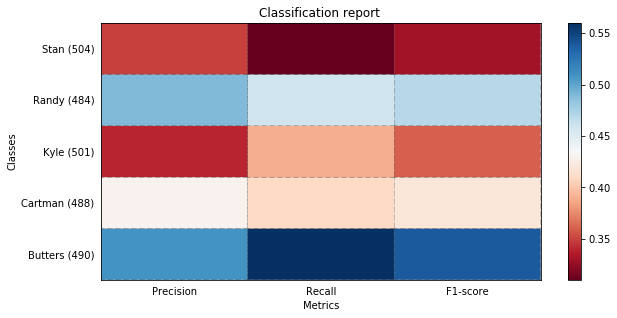

In [17]:
plot_classification_report(classification_report(y_test, preds))

Confusion matrix, without normalization
[[274  50  71  52  43]
 [ 61 201  93  62  71]
 [ 55  85 193  56 112]
 [ 77  43  75 222  67]
 [ 66  88 133  59 158]]


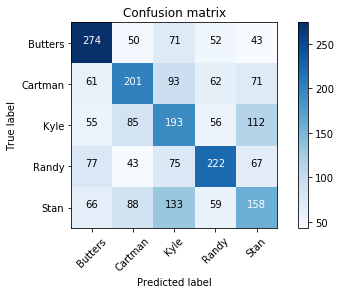

In [18]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=best_clf.classes_, normalize=False,
                      title='Confusion matrix')